In [45]:
import os, sys, subprocess
from collections import Counter
from datetime import datetime

import numpy as np
from astropy.table import Table
from astropy.io import fits

import matplotlib.pyplot as plt

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import astropy.table as atpy

In [46]:
# You can set this to a local path if you have the software installed and a copy of the data.
# workdir = os.path.join(os.environ['HOME'], 'scratch', 'desi', 'tutorials', 'fiberassign_obs')
workdir = os.path.join(os.environ['SCRATCH'], 'desi', 'test', 'fiberassign')
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = os.path.join(workdir, 'output')
os.makedirs(outdir, exist_ok=True)


In [47]:
ntiles = 5
tiles = Table()
tile_radius = desimodel.focalplane.get_tile_radius_deg()
tiles['TILEID'] = np.arange(ntiles, dtype='i4')
tiles['RA'] = 2 + np.arange(ntiles)*0.5*tile_radius
tiles['DEC'] = np.zeros(ntiles)
tiles['PASS'] = np.zeros(ntiles, dtype='i2')
tiles['OBSCONDITIONS'] = np.ones(ntiles, dtype='i4') * obsconditions.DARK
tiles['IN_DESI'] = np.ones(ntiles, dtype='i2')
tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
tiles.write('tiles.fits', format='fits', overwrite=True)


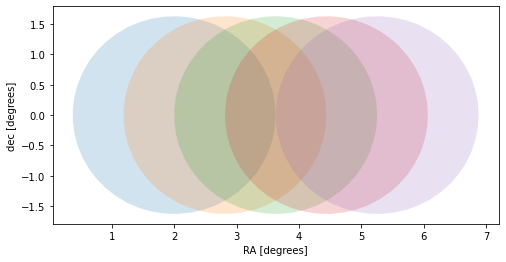

In [48]:
def plot_sky_circle(x, y, radius, alpha=0.2):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha)

def plot_tile(ra, dec, alpha=0.2):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius)

def plot_tiles(tiles):
    for i in range(len(tiles)):
        plot_tile(tiles['RA'][i], tiles['DEC'][i])
    plt.xlabel('RA [degrees]')
    plt.ylabel('dec [degrees]')

plt.figure(figsize=(8,4))
plot_tiles(tiles)

In [49]:
rundatestr = "2022-01-01T00:00:00+00:00"
rundate = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S+00:00")
print(rundate)

2022-01-01 00:00:00


Text(0, 0.5, 'dec [degrees]')

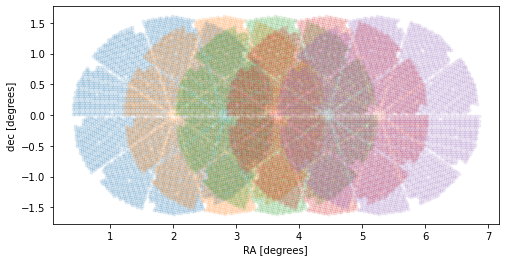

In [50]:
def plot_positioners(tilera, tiledec, alpha=0.1):
    fp, exclude, state, tmstr = desimodel.io.load_focalplane(time=rundate)
    # Select just science positioners
    rows = np.where(fp['DEVICE_TYPE'] == 'POS')[0]
    fp = fp[rows]
    ra, dec = desimodel.focalplane.xy2radec(tilera, tiledec, fp['OFFSET_X'], fp['OFFSET_Y'])
    plt.plot(ra, dec, '.', alpha=alpha)

plt.figure(figsize=(8,4))
for i in range(len(tiles)):
    plot_positioners(tiles['RA'][i], tiles['DEC'][i])

plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')


Random targets

In [51]:
def generate_random_targets(density, tiles):
    #- Get basic bounds; don't worry about RA wraparound for this example
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    ramin = np.min(tiles['RA'] - tile_radius*np.cos(np.radians(tiles['DEC'])))
    ramax = np.max(tiles['RA'] + tile_radius*np.cos(np.radians(tiles['DEC'])))
    decmin = np.min(tiles['DEC']) - tile_radius
    decmax = np.max(tiles['DEC']) + tile_radius
    
    area = (ramax-ramin) * np.degrees((np.sin(np.radians(decmax)) - np.sin(np.radians(decmin))))
    n = int(area*density)

    #- Iterate if needed to get unique TARGETIDs
    while True:
        targetids = np.random.randint(0, 2**62-1, n)
        if len(set(targetids)) == n:
            break

    #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = np.random.uniform(ramin, ramax, n)
    phimin = np.radians(90-decmin)
    phimax = np.radians(90-decmax)
    targets['DEC'] = 90-np.degrees(np.arccos(np.random.uniform(np.cos(phimin), np.cos(phimax), n)))
    targets['DESI_TARGET'] = np.zeros(n, dtype='i8')
    targets['BGS_TARGET'] = np.zeros(n, dtype='i8')
    targets['MWS_TARGET'] = np.zeros(n, dtype='i8')
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    targets['BRICKID'] = np.full(n, 0)    #- required !?!
    targets['BRICK_OBJID'] = np.arange(n)
    
    #- dummy values for fluxes
    for filt in ['G', 'R', 'Z']:
        targets['FIBERFLUX_'+filt] = np.zeros(n, dtype='f4')
        targets['FIBERFLUX_IVAR_'+filt] = np.ones(n, dtype='f4')
    
    #- Trim to targets that are covered by a tile
    ii = desimodel.footprint.is_point_in_desi(tiles, targets['RA'], targets['DEC'])
    targets = targets[ii]
    
    return targets

In [52]:
#- ELG-like sample: high density, only one requested observation per target
density = 2400
targets = generate_random_targets(density, tiles)
n = len(targets)
#targets['PRIORITY'] = 
#targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n, dtype='i8')
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [53]:
#- Sky targets at 4x the density of fibers
fiber_density = 5000 / 7.5
sky_density = 4*fiber_density
sky = generate_random_targets(sky_density, tiles)
nsky = len(sky)
sky['DESI_TARGET'] = desi_mask.SKY
sky['OBSCONDITIONS'] = np.ones(nsky, dtype='i4') * obsconditions.mask('DARK|GRAY|BRIGHT')
sky.meta['EXTNAME'] = 'SKY'
sky.write('sky.fits', overwrite=True)

In [54]:
std_density = 50
stdstars = generate_random_targets(std_density, tiles)
nstd = len(stdstars)
stdstars['SUBPRIORITY'] = np.random.uniform(0, 1, nstd)
stdstars['DESI_TARGET'] = desi_mask.STD_FAINT
stdstars['OBSCONDITIONS'] = np.ones(nstd, dtype='i4') * obsconditions.DARK
stdstars.meta['EXTNAME'] = 'STD'
stdstars.write('stdstars.fits', overwrite=True)


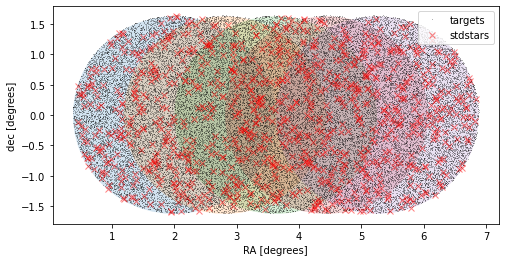

In [55]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'], targets['DEC'], 'k,', alpha=0.3, label='targets')
plt.plot(stdstars['RA'], stdstars['DEC'], 'rx', alpha=0.5, label='stdstars')
plot_tiles(tiles)
plt.legend()

Run fiberassign on those targets/satndards/sky

In [56]:
cmd = 'fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits'
cmd += ' --rundate {}'.format(rundatestr)
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())

RUNNING: fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --rundate 2022-01-01T00:00:00+00:00 --footprint ./tiles.fits --outdir ./output/
INFO: Keeping 943 standards that aren't already in MTL
INFO: Loaded focalplane for time stamp 2022-01-01 00:00:00+00:00
INFO: Focalplane has 741 fibers that are stuck or broken
INFO: Target file mtl.fits has 45205 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in target file; using RA,DEC or TARGET_RA,DEC
INFO: Read target file mtl.fits:  0.05 seconds (1 calls)
INFO: Target file /tmp/tmpl516aq_m/standards.fits has 943 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in

fiberassign output

In [57]:
fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tiles['TILEID'][0])
fx = fits.open(fafile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL_ASSIGNMENTS columns:')
print(fx['POTENTIAL_ASSIGNMENTS'].data.dtype.names)
fx.close()

Filename: /global/cscratch1/sd/jding/desi/test/fiberassign/output/fiberassign-000000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  FIBERASSIGN    1 BinTableHDU    134   5000R x 31C   [K, I, J, J, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, 8A, J, J, E, E, E, K, K, K, D, D]   
  2  SKY_MONITOR    1 BinTableHDU    112   20R x 20C   [J, J, K, J, J, K, B, D, D, E, E, 8A, J, I, J, J, D, E, E, E]   
  3  TARGETS       1 BinTableHDU     94   4271R x 11C   [K, D, D, K, B, J, D, J, K, K, K]   
  4  POTENTIAL_ASSIGNMENTS    1 BinTableHDU     78   36919R x 3C   [K, J, J]   
  5  FASSIGN       1 BinTableHDU    104   5020R x 16C   [J, K, J, J, E, I, J, 3A, D, D, K, B, E, E, D, D]   
  6  FTARGETS      1 BinTableHDU     92   4271R x 10C   [K, D, D, K, B, J, D, J, D, D]   
  7  FAVAIL        1 BinTableHDU     78   36919R x 3C   [J, J, K]   
None

FIBERASSIGN columns:
('TARGETID', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', '

In [14]:
assignments = list()
for tileid in tiles['TILEID']:
    fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(fafile, 'FIBERASSIGN'))

In [15]:
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.isin(targets['TARGETID'], assigned_targetids)

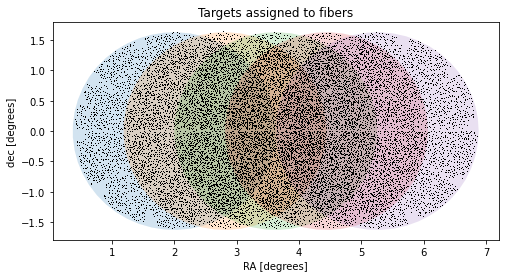

In [16]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plot_tiles(tiles)

And which targets weren't assigned?

Text(0.5, 1.0, 'Targets not assigned to fibers')

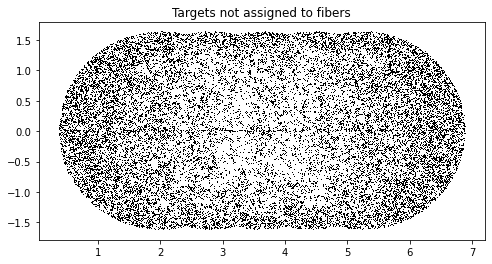

In [17]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets not assigned to fibers')


In [18]:
num_assigned = np.count_nonzero(isAssigned)
max_possible_assigned = int(len(tiles) * 5000 * 0.9)  #- 10% of fibers are reserved for std and sky calibrators
print('Targets assigned        ', num_assigned)
print('Max possible assignments', max_possible_assigned)
print('Ratio                   ', num_assigned/max_possible_assigned)

Targets assigned         18964
Max possible assignments 22500
Ratio                    0.8428444444444444


Assigning a target more than once - part I

In [19]:
#- Science Verification sample: high density, with multiple requested observations per target
density = 2400
targets = generate_random_targets(density, tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n, dtype='i8') * 4  #- THIS IS WHAT IS DIFFERENT THAN BEFORE
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [20]:
#- Rerun fiberassign
#- Rerun fiberassign
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())

RUNNING: fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --rundate 2022-01-01T00:00:00+00:00 --footprint ./tiles.fits --outdir ./output/
INFO: Keeping 938 standards that aren't already in MTL
INFO: Loaded focalplane for time stamp 2022-01-01 00:00:00+00:00
INFO: Focalplane has 741 fibers that are stuck or broken
INFO: Target file mtl.fits has 45231 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in target file; using RA,DEC or TARGET_RA,DEC
INFO: Read target file mtl.fits:  0.07 seconds (1 calls)
INFO: Target file /tmp/tmp8g9y91w0/standards.fits has 938 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in

Histogram how many times each target was assigned

In [13]:
def get_assigned_covered(tiles):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(fafile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(fafile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(ids):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

In [14]:
assigned_ids, covered_ids = get_assigned_covered(tiles)
assigned_count = count_coverage(assigned_ids)
covered_count = count_coverage(covered_ids)

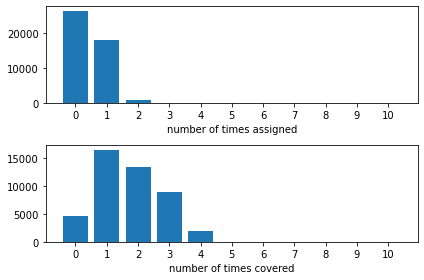

In [15]:
plt.subplot(211)
plt.hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times assigned')

plt.subplot(212)
plt.hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times covered')

plt.tight_layout()


Assigning a target more than once - part II

In [24]:
#- QSO-like sample: low density, multiple observations per target
density = 50  #- 
targets = generate_random_targets(density, tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n, dtype='i8') * 4  #- THIS IS WHAT IS DIFFERENT THAN BEFORE
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [21]:
#- Rerun fiberassign
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())

RUNNING: fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --rundate 2022-01-01T00:00:00+00:00 --footprint ./tiles.fits --outdir ./output/
INFO: Keeping 936 standards that aren't already in MTL
INFO: Loaded focalplane for time stamp 2022-01-01 00:00:00+00:00
INFO: Focalplane has 741 fibers that are stuck or broken
INFO: Target file mtl.fits has 945 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in target file; using RA,DEC or TARGET_RA,DEC
INFO: Read target file mtl.fits:  0.00 seconds (1 calls)
INFO: Target file /tmp/tmpd9mk8u76/standards.fits has 936 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counted as TARGET_TYPE_STANDARD
INFO: Warning: no PLATE_RA, PLATE_DEC in t

In [74]:
assigned_ids, covered_ids = get_assigned_covered(tiles)
assigned_count = count_coverage(assigned_ids)
covered_count = count_coverage(covered_ids)

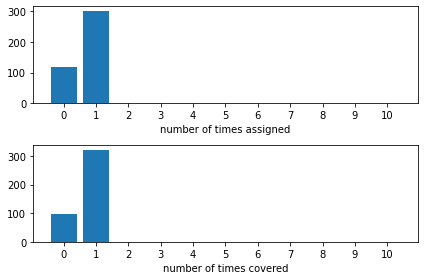

In [66]:
plt.subplot(211)
plt.hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times assigned')

plt.subplot(212)
plt.hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times covered')

plt.tight_layout()

In [67]:
n2d = np.zeros((10, 10), dtype=int)

count_assigned = Counter(assigned_ids)
count_covered = Counter(covered_ids)

for tid in targets['TARGETID']:
    n = count_assigned[tid]
    m = count_covered[tid]
    n2d[n,m] += 1

Text(0, 0.5, 'Number of times Assigned')

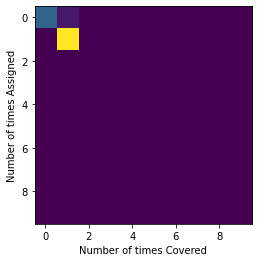

In [68]:
plt.imshow(n2d)
plt.xlabel('Number of times Covered')
plt.ylabel('Number of times Assigned')

In [ ]:
def read_targets(fname):
    T=atpy.Table().read(fname)
    priority = pd.read_csv('/global/u2/j/jding/MKY_DESI/priority_pppmcut_19092.csv')
    targetids = np.arange(len(T))
    ra,dec=T['RA'],T['DEC']
    n = len(ra)
    #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = ra
    targets['DEC']=dec
    targets['DESI_TARGET'] = np.zeros(n, dtype='i8')
    targets['BGS_TARGET'] = np.zeros(n, dtype='i8')
    targets['MWS_TARGET'] = np.zeros(n, dtype='i8')
    #targets['PRIORITY'][:1768] = np.repeat(5000,1768)
    #targets['PRIORITY'] = 1000
    #setting priority
    targets['PRIORITY'] = priority['pri']
    print (priority['pri'])
    #np.append(np.repeat(5000,1409),np.repeat(3000,22264-1409))
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    targets['BRICKID'] = np.full(n, 0)    #- required !?!
    targets['BRICK_OBJID'] = np.arange(n)
    
    #- dummy values for fluxes
    for filt in ['G', 'R', 'Z']:
        targets['FIBERFLUX_'+filt] = np.zeros(n, dtype='f4')
        targets['FIBERFLUX_IVAR_'+filt] = np.ones(n, dtype='f4')
    
    #- Trim to targets that are covered by a tile
    ii = desimodel.footprint.is_point_in_desi(tiles, targets['RA'], targets['DEC'])
    targets = targets[ii]
    print (len(targets))
    return targets

In [20]:

hdul = fits.open('/global/u2/j/jding/MKY_DESI/r22.5.fits')



In [21]:
hdul2 = fits.open('/global/u2/j/jding/fba/targets.fits')


In [22]:
len(hdul2[1].data)


2

In [23]:
hdul2[1].header['NAXIS2']=18557 



In [34]:
fname = '/global/u2/j/jding/MKY_DESI/r22.5_radec_pppmcut_19092_new.fits'
#ra0=229.63
#dec0=0.83
ra0=229.6
dec0=1.1
#0.96
workdir='./'

#fname,ra0,dec0,workdir=sys.argv[1],float(sys.argv[2]),float(sys.argv[3]),str(workdir)

#os.makedirs(workdir, exist_ok=True)

#os.chdir(workdir)

#outdir = os.path.join(workdir, 'output')
#os.makedirs(outdir, exist_ok=True)





In [35]:
import pandas as pd


2022-01-01 00:00:00
0        5000
1        5000
2        5000
3        5000
4        5000
         ... 
19087    3000
19088    3000
19089    3000
19090    3000
19091    3000
Name: pri, Length: 19092, dtype: int64
13889
PRIORITY
--------
    1000
    5000
    5000
    5000
    5000
    1000
    1000
    1000
    1000
    1000
     ...
    3000
    3000
    3000
    3000
    3000
    3000
    3000
    3000
    3000
    3000
    3000
Length = 13889 rows
RUNNING: fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --rundate 2022-01-01T00:00:00+00:00 --footprint ./tiles.fits --outdir ./output/
INFO: Keeping 415 standards that aren't already in MTL
INFO: Loaded focalplane for time stamp 2022-01-01 00:00:00+00:00
INFO: Focalplane has 741 fibers that are stuck or broken
INFO: Target file mtl.fits has 13889 rows.  Reading in chunks of 1000000
INFO: rundate = 2022-01-01T00:00:00+00:00 is after rundate_cutoff_std_wd = 2021-12-01T19:00:00+00:00, so STD_WD are *not* counte

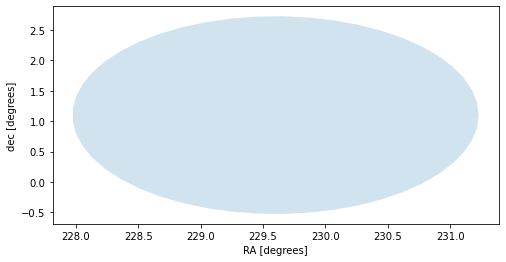

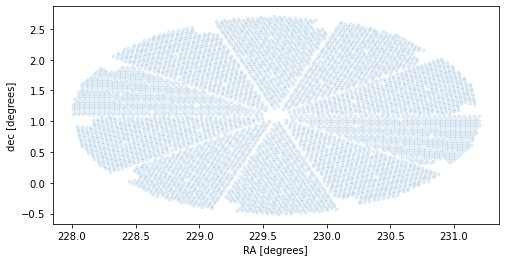

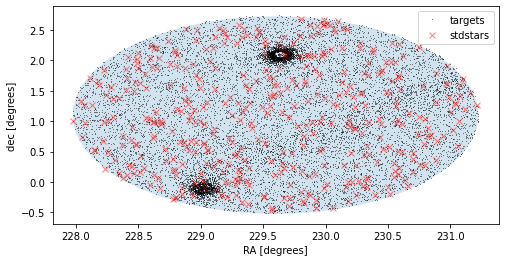

In [36]:

ntiles = 1
tiles = Table()

tile_radius = desimodel.focalplane.get_tile_radius_deg()
tiles['TILEID'] = np.arange(ntiles, dtype='i4')
tiles['RA'] = ra0 + np.arange(ntiles)*0.5*tile_radius
tiles['DEC'] = dec0+np.zeros(ntiles)
tiles['PASS'] = np.zeros(ntiles, dtype='i2')
tiles['OBSCONDITIONS'] = np.ones(ntiles, dtype='i4') * obsconditions.DARK
tiles['IN_DESI'] = np.ones(ntiles, dtype='i2')
tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
tiles.write('tiles.fits', format='fits', overwrite=True)




def plot_sky_circle(x, y, radius, alpha=0.2):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha)

def plot_tile(ra, dec, alpha=0.2):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius)

def plot_tiles(tiles):
    for i in range(len(tiles)):
        plot_tile(tiles['RA'][i], tiles['DEC'][i])
    plt.xlabel('RA [degrees]')
    plt.ylabel('dec [degrees]')

plt.figure(figsize=(8,4))
plot_tiles(tiles)

rundatestr = "2022-01-01T00:00:00+00:00"
rundate = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S+00:00")
print(rundate)


def plot_positioners(tilera, tiledec, alpha=0.1):
    fp, exclude, state, tmstr = desimodel.io.load_focalplane(time=rundate)
    # Select just science positioners
    rows = np.where(fp['DEVICE_TYPE'] == 'POS')[0]
    fp = fp[rows]
    ra, dec = desimodel.focalplane.xy2radec(tilera, tiledec, fp['OFFSET_X'], fp['OFFSET_Y'])
    plt.plot(ra, dec, '.', alpha=alpha)
    df = pd.DataFrame()
    df['RA']=ra
    df['DEC']=dec
    t = Table.from_pandas(df)
    t.write('/global/u2/j/jding/MKY_DESI/r22.5_radec_0.1_1.05_229.6_19092_1.1.fits')

plt.figure(figsize=(8,4))
for i in range(len(tiles)):
    plot_positioners(tiles['RA'][i], tiles['DEC'][i])

plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')




#- ELG-like sample: high density, only one requested observation per target
density = 2400
targets = read_targets(fname)
n = len(targets)
#targets['PRIORITY'] = 1000
#targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
print (targets['PRIORITY'])
#targets['PRIORITY'] = np.append(np.repeat(3000,1768),np.repeat(1000,14806-1768))
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n, dtype='i8')
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)




#- Sky targets at 4x the density of fibers
fiber_density = 5000 / 7.5
sky_density = 4*fiber_density
sky = generate_random_targets(sky_density, tiles)
nsky = len(sky)
sky['DESI_TARGET'] = desi_mask.SKY
sky['OBSCONDITIONS'] = np.ones(nsky, dtype='i4') * obsconditions.mask('DARK|GRAY|BRIGHT')
sky.meta['EXTNAME'] = 'SKY'
sky.write('sky.fits', overwrite=True)



std_density = 50
stdstars = generate_random_targets(std_density, tiles)
nstd = len(stdstars)
stdstars['SUBPRIORITY'] = np.random.uniform(0, 1, nstd)
stdstars['DESI_TARGET'] = desi_mask.STD_FAINT
stdstars['OBSCONDITIONS'] = np.ones(nstd, dtype='i4') * obsconditions.DARK
stdstars.meta['EXTNAME'] = 'STD'
stdstars.write('stdstars.fits', overwrite=True)




plt.figure(figsize=(8,4))
plt.plot(targets['RA'], targets['DEC'], 'k,', alpha=0.5, label='targets')
plt.plot(stdstars['RA'], stdstars['DEC'], 'rx', alpha=0.5, label='stdstars')
plot_tiles(tiles)
plt.legend()




cmd = 'fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits'
cmd += ' --rundate {}'.format(rundatestr)
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    


In [37]:
# You can set this to a local path if you have the software installed and a copy of the data.
# workdir = os.path.join(os.environ['HOME'], 'scratch', 'desi', 'tutorials', 'fiberassign_obs')
workdir = os.path.join(os.environ['SCRATCH'], 'desi', 'test', 'fiberassign')
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = os.path.join(workdir, 'output')
os.makedirs(outdir, exist_ok=True)

In [ ]:
cmd = 'fiberassign --overwrite --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits'
cmd += ' --rundate {}'.format(rundatestr)
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())

In [ ]:
fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tiles['TILEID'][0])
fx = fits.open(fafile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL_ASSIGNMENTS columns:')
print(fx['POTENTIAL_ASSIGNMENTS'].data.dtype.names)
fx.close()

In [ ]:
assignments = list()
for tileid in tiles['TILEID']:
    fafile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(fafile, 'FIBERASSIGN'))
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.isin(targets['TARGETID'], assigned_targetids)   
    

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plot_tiles(tiles)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()
df['RA']=targets['RA'][isAssigned]
df['DEC']=targets['DEC'][isAssigned]
df.to_csv('/global/u2/j/jding/MKY_DESI/pal5s19092_nonpri.csv')


In [ ]:
num_assigned = np.count_nonzero(isAssigned)
max_possible_assigned = int(len(tiles) * 5000 * 0.9)  #- 10% of fibers are reserved for std and sky calibrators
print('Targets assigned        ', num_assigned)
print('Max possible assignments', max_possible_assigned)
print('Ratio                   ', num_assigned/max_possible_assigned)

In [40]:
# 22264 0.86
# 24352 0.86